<a href="https://colab.research.google.com/github/nsackheim/Coursera_Capstone/blob/master/Kilarc_Autoregressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
#@title File upload
# Upload a file to the local directory
from google.colab import files
uploaded = files.upload()

Saving 8-16-probably_2016_datat _CSV.csv to 8-16-probably_2016_datat _CSV.csv


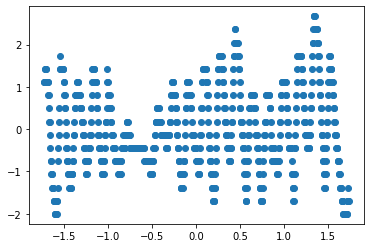

In [41]:
#@title Retrieve temperature data
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_data(N=0,standardize=False,daily=False):
  df = pd.read_csv('8-16-probably_2016_datat _CSV.csv', error_bad_lines=False)
  if N == 0:
    N = len(df)
  X = np.arange(N)
  Y = np.array(df['59'][:N])

  if standardize:
    X,Y = X.reshape(-1,1), Y.reshape(-1,1)
    scaler = StandardScaler()
    X,Y = scaler.fit_transform(X), scaler.fit_transform(Y)
    global mu,var
    mu,var = scaler.mean_,scaler.var_

  if daily:
    n_days = len(X)//24

    X_daily = np.arange(n_days)
    Y_daily = np.zeros(n_days)

    for i in range(n_days):
      Y_daily[i] = np.mean(Y[24*i:24*(i+1)])

    X,Y = X_daily, Y_daily

  X,Y = X.reshape(-1,1), Y.reshape(-1,1)
  return X,Y

#Retrieve and plot data
Xt,Yt = get_data(925, standardize=True)
plt.scatter(Xt,Yt)

In [38]:
### build the dataset
# let's see if we can use T past values to predict the next value

def T_data(T,X=Xt,Y=Yt):
    X_T = []
    Y_T = [] 
    for t in range(len(X) - T+1):
      x_T = Xt[t:t+T]
      X_T.append(x_T)
      y_T = Yt[t+T]
      Y_T.append(y_T)

    X,Y = np.array(X_T).reshape(-1,T), np.array(Y_T).reshape(-1,1)
    return X,Y

X,Y = T_data(10)

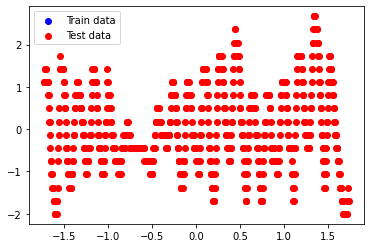

In [32]:
#@title Train/test data split
from sklearn.model_selection import train_test_split

def data_split(Xt,Yt,X,Y,test_size=0.33,random_state=None):
    Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt, Yt, test_size=test_size, random_state=random_state)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    plt.scatter(Xt_train,Yt_train,color='blue',label='Train data')
    plt.scatter(Xt_test,Yt_test,color='red',label='Test data')
    plt.legend(); plt.show()

    return Xt_train, Xt_test, Yt_train, Yt_test, X_train, X_test, Y_train, Y_test

Xt_train, Xt_test, Yt_train, Yt_test, X_train, X_test, Y_train, Y_test = data_split(Xt,Yt,X,Y, test_size=0.997)

In [8]:
#@title Initialize model function
m1,m2,m3 = 128,16,128
def init_model(TT,m1,m2,m3):
  global model, criterion, optimizer
  model = nn.Sequential(
    nn.Linear(TT, m1),
    nn.ReLU(),
#    nn.Linear(m1, m2),
#    nn.ReLU(),
#    nn.Linear(m2, m3),
#    nn.ReLU(),
    nn.Linear(m3, 1)
)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

In [9]:
#@title Full gradient descent train function
def full_gd(model, criterion, optimizer, X_train, Y_train, X_test,Y_test, n_epochs=1000):
  X_train = torch.from_numpy(X_train.astype(np.float32))
  Y_train = torch.from_numpy(Y_train.astype(np.float32).reshape(-1, 1))

  X_test = torch.from_numpy(X_test.astype(np.float32))
  Y_test = torch.from_numpy(Y_test.astype(np.float32).reshape(-1, 1))  
  
  # Stuff to store
  train_losses = np.zeros(n_epochs)
  test_losses = np.zeros(n_epochs)

  for it in range(n_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, Y_train)

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, Y_test)

    # Backward and optimize
    test_loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = train_loss.item()
    test_losses[it] = test_loss.item()

    ##if (it + 1) % 50 == 0:
      ## print(f'Epoch {it+1}/{n_epochs}, Train_Loss: {train_loss.item():.4f}, Test_Loss: {train_loss.item():.4f}')
      ## Plot the loss per iteration
  #plt.plot(train_losses,'b-',label='Train losses')
  #plt.plot(test_losses,'r-',label='Test losses'); plt.legend(); plt.show()
  print(f'Epoch {n_epochs}/{n_epochs}, Train_Loss: {train_loss.item():.4f}, Test_Loss: {test_loss.item():.4f}, Loss_Ratio: {test_loss.item()/train_loss.item():.4f}')

  return train_loss.item(), test_loss.item()

In [17]:
#@title Training run function
def run_training(n_epochs):
  t_i = time()

  #global model, criterion, optimizer
  init_model(T,128,1,128)
  train_loss, test_loss = full_gd(model, criterion, optimizer, X_train, Y_train, X_test,Y_test,n_epochs=n_epochs)

  t_f = time()
  run_time = t_f-t_i; print(f'run time = {run_time}')
  return train_loss, test_loss

#run_training(1000);

In [12]:
#@title Plot the fitted predictions

def plot_regression():
  plt.scatter(Xt, Yt, label='Original data')

  inputs = torch.from_numpy(X.astype(np.float32))
  predicted = model(inputs).detach().numpy()

  plt.plot(Xt[:-T], predicted, 'r-',label='Regression Curve'); plt.legend()
  plt.show()

#plot_regression()

In [42]:
T = 1
Xt,Yt = get_data(4, standardize=True) # N = 925
print(X.shape,Y.shape,Xt.shape,Yt.shape)
X,Y = T_data(T)
Xt_train, Xt_test, Yt_train, Yt_test, X_train, X_test, Y_train, Y_test = data_split(Xt,Yt,X,Y,test_size=0.5,random_state=24)

run_training(2000)
plot_regression()

(0, 10) (0, 1) (4, 1) (4, 1)


IndexError: ignored

In [24]:
  T = 10
  Xt,Yt = get_data(925, standardize=True)
  X,Y = T_data(10)

  final_train_losses = []
  final_test_losses = []
  final_losses = []
  loss_ratios = []

for i in range(10):
    Xt_train, Xt_test, Yt_train, Yt_test, X_train, X_test, Y_train, Y_test = data_split(Xt,Yt,X,Y,test_size=0.98)
    final_train_loss,final_test_loss = run_training(2000)
    final_train_losses.append(final_train_loss);final_test_losses.append(final_test_loss)
    final_losses.append([final_train_loss,final_test_loss])
    loss_ratios.append([final_test_loss/final_train_loss])
    #plot_regression()

loss_ratios = np.array(loss_ratios)
print(np.mean(loss_ratios),np.var(loss_ratios))
print(loss_ratios)

Epoch 2000/2000, Train_Loss: 1.1703, Test_Loss: 0.7300, Loss_Ratio: 0.6238
run time = 2.7644572257995605
Epoch 2000/2000, Train_Loss: 0.7104, Test_Loss: 0.7202, Loss_Ratio: 1.0138
run time = 2.738389492034912
Epoch 2000/2000, Train_Loss: 0.9978, Test_Loss: 0.7233, Loss_Ratio: 0.7249
run time = 2.7664005756378174
Epoch 2000/2000, Train_Loss: 1.0383, Test_Loss: 0.7203, Loss_Ratio: 0.6937
run time = 2.701023817062378
Epoch 2000/2000, Train_Loss: 0.5521, Test_Loss: 0.7408, Loss_Ratio: 1.3418
run time = 2.778383493423462
Epoch 2000/2000, Train_Loss: 0.5489, Test_Loss: 0.7256, Loss_Ratio: 1.3220
run time = 2.839808225631714
Epoch 2000/2000, Train_Loss: 0.7647, Test_Loss: 0.7318, Loss_Ratio: 0.9570
run time = 2.8086626529693604
Epoch 2000/2000, Train_Loss: 0.4402, Test_Loss: 0.7289, Loss_Ratio: 1.6557
run time = 2.8350718021392822
Epoch 2000/2000, Train_Loss: 0.7870, Test_Loss: 0.7313, Loss_Ratio: 0.9292
run time = 2.8284552097320557
Epoch 2000/2000, Train_Loss: 1.2460, Test_Loss: 0.7120, Los

In [23]:
  T = 10
  Xt,Yt = get_data(925, standardize=True)
  X,Y = T_data(10)

  final_train_losses = []
  final_test_losses = []
  final_losses = []
  loss_ratios = []

for i in range(10):
    Xt_train, Xt_test, Yt_train, Yt_test, X_train, X_test, Y_train, Y_test = data_split(Xt,Yt,X,Y,test_size=0.50)
    final_train_loss,final_test_loss = run_training(2000)
    final_train_losses.append(final_train_loss);final_test_losses.append(final_test_loss)
    final_losses.append([final_train_loss,final_test_loss])
    loss_ratios.append([final_test_loss/final_train_loss])
    #plot_regression()

loss_ratios = np.array(loss_ratios)
print(np.mean(loss_ratios),np.var(loss_ratios))
print(loss_ratios)

Epoch 2000/2000, Train_Loss: 0.7471, Test_Loss: 0.7416, Loss_Ratio: 0.9927
run time = 1.9750392436981201
Epoch 2000/2000, Train_Loss: 0.8171, Test_Loss: 0.7223, Loss_Ratio: 0.8839
run time = 2.0159497261047363
Epoch 2000/2000, Train_Loss: 0.7660, Test_Loss: 0.7092, Loss_Ratio: 0.9258
run time = 2.008222818374634
Epoch 2000/2000, Train_Loss: 0.8206, Test_Loss: 0.7275, Loss_Ratio: 0.8865
run time = 2.0450804233551025
Epoch 2000/2000, Train_Loss: 0.7917, Test_Loss: 0.6804, Loss_Ratio: 0.8594
run time = 1.960791826248169
Epoch 2000/2000, Train_Loss: 0.7560, Test_Loss: 0.6962, Loss_Ratio: 0.9209
run time = 2.0239648818969727
Epoch 2000/2000, Train_Loss: 0.7364, Test_Loss: 0.7446, Loss_Ratio: 1.0112
run time = 2.0545389652252197
Epoch 2000/2000, Train_Loss: 0.7408, Test_Loss: 0.7290, Loss_Ratio: 0.9841
run time = 1.9680182933807373
Epoch 2000/2000, Train_Loss: 0.8034, Test_Loss: 0.6781, Loss_Ratio: 0.8441
run time = 1.9902632236480713
Epoch 2000/2000, Train_Loss: 0.7451, Test_Loss: 0.7043, L